In [2]:
import torch
import torchvision

from torch import nn
from torchsummary import summary
import torch.nn.functional as F
from torchvision import transforms

In [3]:
import numpy as np
import cv2
import os
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pprint import pprint
import PIL

In [20]:
class OmniglotSet(torch.utils.data.Dataset):
    
    def __init__(self,root_dir,setsize,transform,language=None):
        path = os.path.join(root_dir,'omniglot-py','images_background')
        print('choose the following language',os.listdir(path))
        
        self.root_dir = path
        self.language = language
        self.setsize = setsize
        self.transform = transform
        
    def __len__(self):
        return self.setsize
        
    def __getitem__(self,idx):
        language = os.listdir(self.root_dir)
        
        if self.language is None:
            language = np.random.choice(language)
        else:
            language = self.language
            
        lang_path = os.path.join(self.root_dir,language)
        char = os.listdir(lang_path)
        
        if idx % 2 == 0:
            char1 = np.random.choice(char)
            char2 = np.random.choice(char)
        else:
            char1 = np.random.choice(char)
            char2 = char1
        label = 1 if char1 == char2 else 0
        
        img1_path = np.random.choice(glob(os.path.join(lang_path,char1,'*')))
        img2_path = np.random.choice(glob(os.path.join(lang_path,char2,'*')))

        img1 = PIL.Image.open(img1_path)
        img2 = PIL.Image.open(img2_path)
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.Tensor([label])

In [21]:
class net(nn.Module):
    
    def __init__(self):
        super(net,self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1,32,10),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(32,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(64,128,3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.clf = nn.Sequential(
            nn.Linear(9*9*128,256),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Linear(256,1)
                
    def feature_extract(self,x):
        tmp = self.conv_1(x)
        tmp = self.conv_2(tmp)
        tmp = self.conv_3(tmp)
        tmp = tmp.view(-1,9*9*128)
        tmp = self.clf(tmp)
        
        return tmp
        
    def forward(self,x,y):
        tmp = self.feature_extract(x)

        tmp2 = self.feature_extract(y)
        
        tmp3 = torch.abs(tmp - tmp2)
                
        tmp3 = self.out(tmp3)
        
        return tmp3

In [22]:
dataset = OmniglotSet('data',1000,transforms.ToTensor(),language='Armenian')

choose the following language ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


In [23]:
loader = torch.utils.data.DataLoader(dataset,batch_size=128,shuffle=True,num_workers=0)

In [16]:
model = net().cuda()

In [8]:
summary(model,[(1,105,105),(1,105,105)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]           3,232
       BatchNorm2d-2           [-1, 32, 96, 96]              64
              ReLU-3           [-1, 32, 96, 96]               0
         MaxPool2d-4           [-1, 32, 48, 48]               0
            Conv2d-5           [-1, 64, 42, 42]         100,416
       BatchNorm2d-6           [-1, 64, 42, 42]             128
              ReLU-7           [-1, 64, 42, 42]               0
         MaxPool2d-8           [-1, 64, 21, 21]               0
            Conv2d-9          [-1, 128, 19, 19]          73,856
      BatchNorm2d-10          [-1, 128, 19, 19]             256
             ReLU-11          [-1, 128, 19, 19]               0
        MaxPool2d-12            [-1, 128, 9, 9]               0
           Linear-13                  [-1, 256]       2,654,464
             ReLU-14                  [

In [9]:
model(torch.randn(2,1,105,105).cuda(),torch.randn(2,1,105,105).cuda()).shape

torch.Size([2, 1])

In [17]:
criterion = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(),weight_decay=0.05)

In [18]:
epoch = 50

In [24]:
training_loss = []
model.train()
for e in range(epoch):
    runningLoss = 0.0
    for i, data in enumerate(tqdm(loader)):
        img, img2, label = data
        
        img = img.cuda()
        img2 = img2.cuda()
        label = label.cuda()
        
        output = model(img,img2)
        
        optim.zero_grad()
        loss = criterion(output,label)
        loss.backward()
        optim.step()

        runningLoss += loss.item()
        
        img.detach().cpu()
        img2.detach().cpu()
        label.detach().cpu()
    print(f'epoch:{e+1}, loss: {runningLoss/len(dataset)}')
    training_loss.append(runningLoss/len(dataset))


epoch:1, loss: 0.005307461798191071



epoch:2, loss: 0.004488328337669372



epoch:3, loss: 0.0038650937974452973



epoch:4, loss: 0.004043661236763



epoch:5, loss: 0.0038981242179870605



epoch:6, loss: 0.003668229669332504



epoch:7, loss: 0.00353057524561882



epoch:8, loss: 0.0037029343247413633



epoch:9, loss: 0.0033927799463272096



epoch:10, loss: 0.0032888012826442718



epoch:11, loss: 0.003364026606082916



epoch:12, loss: 0.0031884902715682982



epoch:13, loss: 0.003074706047773361



epoch:14, loss: 0.0028133381009101868



epoch:15, loss: 0.0030639932453632355



epoch:16, loss: 0.0030948475301265715



epoch:17, loss: 0.0030274498760700227



epoch:18, loss: 0.0030340031683444976



epoch:19, loss: 0.0030733447670936585



epoch:20, loss: 0.002939324975013733



epoch:21, loss: 0.0031540772020816803



epoch:22, loss: 0.0028963735699653625



epoch:23, loss: 0.002652294248342514



epoch:24, loss: 0.002753398656845093



epoch:25, loss: 0.002655440717935562



epoch:26, loss: 0.002819605231285095



epoch:27, loss: 0.0027907742857933046



epoch:28, loss: 0.002770099699497223



epoch:29, loss: 0.0028525784611701964



epoch:30, loss: 0.0027985492050647738



epoch:31, loss: 0.002790758430957794



epoch:32, loss: 0.002766310840845108



epoch:33, loss: 0.0025938736498355864



epoch:34, loss: 0.0027475877702236176



epoch:35, loss: 0.002697584241628647



epoch:36, loss: 0.0027430130243301393



epoch:37, loss: 0.0024152762591838836



epoch:38, loss: 0.002611206948757172



epoch:39, loss: 0.0026203232407569885



epoch:40, loss: 0.0026608415842056276



epoch:41, loss: 0.0026285983324050902



epoch:42, loss: 0.002573138952255249



epoch:43, loss: 0.0026122240722179415



epoch:44, loss: 0.002502896696329117



epoch:45, loss: 0.002614806443452835



epoch:46, loss: 0.0026782572269439696



epoch:47, loss: 0.0024169679284095765



epoch:48, loss: 0.002312050461769104



epoch:49, loss: 0.002204867884516716



epoch:50, loss: 0.0022968628704547883


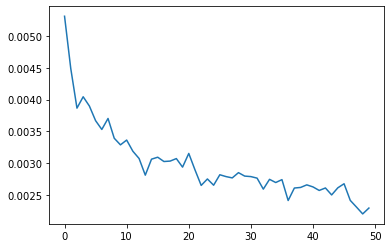

In [25]:
plt.plot(training_loss)

In [26]:
torch.save(model.state_dict(),'siamese.pth')

In [8]:
model.load_state_dict(torch.load('siamese.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [27]:
count = 0
for data in tqdm(loader):
    img1, img2, label = data
    label = label.cuda()
    with torch.no_grad():
        model.eval()
        res = model(img1.cuda(),img2.cuda())
        res = torch.where(res.sigmoid()>=0.5,torch.ones_like(res),torch.zeros_like(res))
        count += torch.sum(res==label).item()
print('acc=',count/len(dataset))


acc= 0.896


In [14]:
# 檢查輸出
for data in tqdm(loader):
    img1, img2, label = data
    label = label.cuda()
    with torch.no_grad():
        model.eval()
        res = model(img1.cuda(),img2.cuda())
        print(res.sigmoid()>0.5)
        print(label)
    break

tensor([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1]], device='cuda:0', dtype=torch.uint8)
tensor([[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')



tensor([0.])



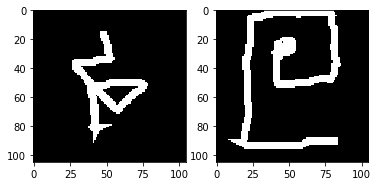

In [14]:
# 繪圖
for data in tqdm(loader):
    img1, img2, label = data
    img1, img2 = img1.numpy(), img2.numpy()
    img1, img2 = np.rollaxis(img1,1,4), np.rollaxis(img2,1,4)
    img1, img2 = np.squeeze(img1,3), np.squeeze(img2,3)

    plt.subplot(1,2,1)
    plt.imshow(img1[0], cmap='gray_r')
    plt.subplot(1,2,2)
    plt.imshow(img2[0], cmap='gray_r')
    print(label[0])
    break

In [28]:
embed = []
for data in tqdm(loader):
    img1,img2,label = data
    img1 = img1.cuda()
    output = model.feature_extract(img1)
    output = output.detach().cpu()
    img1 = img1.detach().cpu()
    embed.append(output)

In [29]:
from umap import UMAP

In [30]:
embed_model = UMAP()
embedding = embed_model.fit_transform(torch.cat(embed).numpy())

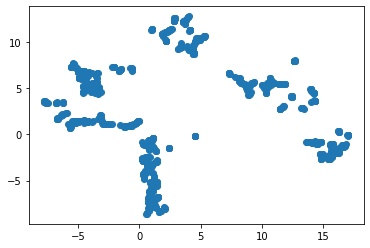

In [31]:
plt.scatter(embedding[:,0],embedding[:,1])